(0, 100)

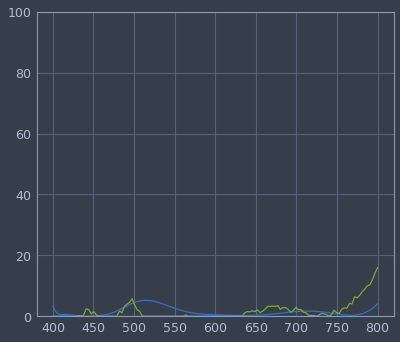

In [590]:
import numpy as np
import mxnet as mx

# Step1: Load the model in MXNet

# Use the same prefix and epoch parameters we used in save_mxnet_model API.
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='siti_fully', epoch=0)


# We use the data_names and data_shapes returned by save_mxnet_model API.
mod = mx.mod.Module(symbol=sym, 
                    data_names=['/first_input9'], 
                    context=mx.gpu(), 
                    label_names=None)
mod.bind(for_training=False, 
         data_shapes=[('/first_input9', (3,16))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

pt = np.array([ 0.79899497,  1.        , -0.79899497, -0.95979899,  0.42713568,
       -1.        ,  1.        ,  1.        ,  0.63819095, -1.        ,
        1.        , -0.59798995, -0.86934673,  0.68844221, -0.34673367,
       -0.77889447])

ttt = np.tile(pt, (1,1))


# data_iter = mx.io.NDArrayIter(ttt, None, 1)
# res2 = mod.predict(data_iter).asnumpy()
# lams = np.linspace(400, 800, endpoint=True, num=128)
# plt.plot(lams, 100*res2[0])
# plt.xlim([400, 800])
# plt.ylim ( [0,100])
# plt.xlabel('wavelength (nm)')


num_layers = 16
d_min = 0.5
d_max = 100 

#geom = np.random.uniform(0,1, 16)

indexx = np.random.randint(0,20)
geom = (bests_g[indexx]-0.5)/99.5
# geom = np.array([0.99740673, 0.16047267, 0.27205694, 0.28930667, 0.39390871,
#        0.12006336, 0.8       , 0.        , 0.50488817, 0.10512654,
#        0.31236766, 0.8        , 0.07536845, 0.15084873, 0.33889699,
#        0.14410015])
# geom[3] = 1.0
# geom[12] = 1.0
geom_ac = rndtop5(0.5 + 99.5*(geom))
#print(geom_ac)
geom_nor = geom*2 - 1 
geom_nor_t = np.tile(geom_nor, (3,1))

# #best_ac = rndtop5(bests_g)

# indexx = 1
# bests_ac = -1.0 + 2.0*(bests_g - 0.5)/99.5 
# R_gp = 100*mod.predict(bests_ac).asnumpy()


# # # #Rs_b = oqx.tmm_eval_wsweep( best_ac   ,0, lam_pts=128)

Rsmod = 100*mod.predict(geom_nor_t)
Rs2 = Rsmod[0].asnumpy()
 
Rs = oqx.tmm_eval_wsweep( geom_ac   ,0, lam_pts=128)
#Rs = oqx.tmm_eval_wsweep( bests_g[indexx]   ,0, lam_pts=128)

lams = np.linspace(400, 800, endpoint=True, num=128)
plt.plot(lams, Rs)
plt.plot(lams, Rs2)
#plt.plot(lams, R_gp[indexx])
plt.ylim([0,100])

#bests_g

In [286]:
np.random.randint(0,100)

37

In [545]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
import numpy as np
import de2 as de
import multiprocessing as mp
import makeqx as mkq
import oldqx as oqx
import mxnet.ndarray as nd


def arc_metric(R_arr):
    pop_size = R_arr.shape[0]
    lam_size = R_arr.shape[1]
    R_ref = np.linspace(0.0, 0.0, endpoint=True, num=lam_size)
    R_ref_tiled = np.tile(R_ref, (pop_size, 1))
    return np.mean(np.abs(R_arr - R_ref_tiled), axis=1) 

def bpass_metric(R_arr):
    b_low = 550
    b_high = 600
    pop_size = R_arr.shape[0]
    lam_size = R_arr.shape[1]
    
    lams = np.linspace(400.0, 800.0, endpoint=True, num=lam_size)
    
    left_r = lams[lams < b_low].size
    right_r = lams[lams <= b_high].size
    R_ref = np.linspace(100.0, 100.0, endpoint=True, num=lam_size)
    R_ref[left_r:right_r]  = 0.0
    
    R_ref_tiled = np.tile(R_ref, (pop_size, 1))
    return np.mean(np.abs(R_arr - R_ref_tiled), axis=1) 
    
    diffarr = np.abs(R_arr - R_ref_tiled)
    passb = np.mean(diffarr[:, left_r:right_r], axis=1)
    stopb = np.mean( diffarr[:, 0:left_r -1], axis=1) + np.mean( diffarr[:, right_r + 1:], axis=1)
    return  stopb + passb

# anti-reflection coating
R_ref = np.linspace(100.0, 100.0, endpoint=True, num=50)
# narrow band transmission filter
R_ref[17] = 0.0


def rndtop5(x):
    return np.round(x*2.0)/2

def tmm_wrapper2(arg):
    args, kwargs = arg
    return oqx.tmm_eval_wsweep(*args, **kwargs)


def arc_par_gp(pop, **kwargs):
    x_in = 2.0*(pop - 0.5)/(99.5) - 1.0
    y_in = 100.0*mod.predict(x_in)
    means = nd.mean(y_in, axis=1)
    return means.asnumpy()




def arc_par(pop, **kwargs):
    jobs = []
    pool=mp.Pool(90)
    for indiv in pop:
        #indiv = indiv.reshape((int(indiv.size/2), 2))
        #indiv[:,1] = mkq.digitize_qx(indiv[:,1], dlevels=2)
        indiv = rndtop5(indiv)
        #indiv = indiv.flatten()
        jobs.append((indiv, 0))
    arg = [(j, kwargs) for j in jobs]
    answ = np.array(pool.map(tmm_wrapper2, arg))
    pool.close()

#     c2 = np.zeros(pop.shape[0])
#     for idx, indiv in enumerate(pop):
#         c2[idx] = np.sum(indiv)
#         if c2[idx] <= 385:
#             c2[idx] = 385/c2[idx]
#         else:
#             c2[idx] = 0.0
    return arc_metric(answ) 
    #return bpass_metric(answ)








bnds = [(d_min, d_max)]*num_layers
its_first = 0
psnew = 5*num_layers
islands_g = 20
its_second = 25
numgens = 3

isl_g = np.ones((psnew*islands_g, num_layers))
for indiv in range(int(psnew*islands_g)):
    isl_g[indiv] = np.random.uniform(0,1, num_layers)

poplist_g = np.split(isl_g, islands_g)

bids_g = np.zeros(islands_g, dtype=int)
bfits_g = np.zeros(islands_g)
bests_g = isl_g[0:islands_g]

for isln in range(islands_g):
    print("----------------- I-" + str(isln + 1)+ "---------------------")
    poplist_g[isln], bids_g[isln], bfits_g[isln], bests_g[isln] = de.de_cp(
        fobj=arc_par_gp, bounds=bnds, 
        pop=poplist_g[isln], 
        history=[], 
        it_start=its_first, 
        popsize=psnew, 
        its=its_second, 
        lam_low=400, 
        lam_high=800, 
        lam_pts=128)



# for gen in range(numgens):
#     print("==============================")
#     print("Epoch #:" + str(gen + 1))
#     print("==============================")
    
#     for isln in range(islands):
#         print("----------------- I-" + str(isln + 1)+ "---------------------")
        
#         if gen == 0:
#             poplist[isln], bids[isln], bfits[isln], bests[isln] = de.de_cp(
#                 fobj=arc_par_gp, bounds=bnds, 
#                 pop=poplist[isln], 
#                 history=[], 
#                 it_start=its_first, 
#                 popsize=psnew, 
#                 its=its_second, 
#                 lam_low=400, 
#                 lam_high=800, 
#                 lam_pts=256)
#         else:
#             poplist[isln], bids[isln], bfits[isln], bests[isln] = de.de_cp(
#                 fobj=arc_par, bounds=bnds, 
#                 pop=poplist[isln], 
#                 history=[], 
#                 it_start=its_first, 
#                 popsize=psnew, 
#                 its=its_second, 
#                 lam_low=400, 
#                 lam_high=800, 
#                 lam_pts=256)

        
#         print(np.sum(bests[isln]))
        
#     if its_second > 64:
#         its_second = int(its_second/2)
    
#     if gen < (numgens - 1):
#         print("Round robin best migration")
#         stmp = np.copy(poplist[islands-1][bids[islands-1]])
#         for isln in range(1, islands):
#             poplist[isln][bids[isln]] = poplist[isln-1][bids[isln-1]]
#         poplist[0][bids[0]] = stmp 
    
# print(bfits) 
# print(bests[np.argmin(bfits)])

# print(np.sum(bests[np.argmin(bfits)]))

----------------- I-1---------------------
19 2.5254126
----------------- I-2---------------------
19 1.0218053
----------------- I-3---------------------
19 2.3306732
----------------- I-4---------------------
19 6.1065593
----------------- I-5---------------------
19 1.26777
----------------- I-6---------------------
19 0.12779659
----------------- I-7---------------------
19 5.573145
----------------- I-8---------------------
19 1.0077518
----------------- I-9---------------------
19 4.2593427
----------------- I-10---------------------
19 1.1253717
----------------- I-11---------------------
19 4.2575607
----------------- I-12---------------------
19 3.3356645
----------------- I-13---------------------
19 1.7500688
----------------- I-14---------------------
19 1.8015399
----------------- I-15---------------------
19 5.98615
----------------- I-16---------------------
19 2.3099566
----------------- I-17---------------------
19 3.7223969
----------------- I-18---------------------


In [59]:
print(bfits_g)


array([6.95943609e-02, 2.73140855e-02, 2.38148496e-03, 0.00000000e+00,
       1.18641138e-01, 4.37494963e-01, 2.25770753e-02, 6.82759564e-03,
       3.18860188e-02, 1.62156439e+00, 2.58233175e-02, 3.02884996e-01,
       1.61414035e-02, 1.01335580e-02, 1.51378568e-02, 1.28030205e+00,
       6.01995029e-02, 1.09164156e-01, 1.44417863e-03, 2.95243934e-02])

In [60]:
arc_par(bests_g)

array([1.25103446, 1.78700328, 2.3109896 , 1.11588667, 1.45650532,
       2.74298038, 0.94518088, 1.82786372, 1.93577577, 9.17519445,
       2.25408966, 2.21879332, 1.94204131, 1.86506282, 1.54120511,
       4.07923547, 2.2086548 , 2.32715269, 1.80240239, 1.64751775])

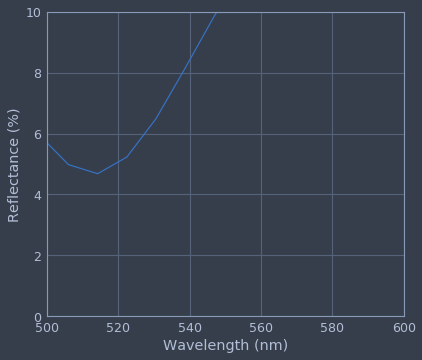

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

#Rs = oqx.tmm_eval_wsweep(rndtop5(bests[np.argmin(bfits)]),0, lam_pts=50)
Rs = oqx.tmm_eval_wsweep(rndtop5(bests_g[ np.random.randint(0,20)  ]),0, lam_pts=50)

#Rs = qn.tmm_eval_wsweep(qx, d_min=2 , d_max=10, inc_ang=0, lam_low=400, lam_high=800, lam_pts=50, n_subs=1.52)  # in nm
lams = np.linspace(400, 800, endpoint=True, num=50)

meanl = np.ones_like(lams)*np.mean(oqx.tmm_eval_wsweep(rndtop5(bests[np.argmin(bfits)]),0))
plt.plot(lams, Rs )
#plt.plot(lams, R_ref)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.ylim([0,10])
plt.xlim([500,600])
plt.show()

In [47]:
R_ref = np.linspace(400.0, 800.0, endpoint=True, num=50)
# narrow band transmission filter
#R_ref[0:83] = 0.0
R_ref

array([400.        , 408.16326531, 416.32653061, 424.48979592,
       432.65306122, 440.81632653, 448.97959184, 457.14285714,
       465.30612245, 473.46938776, 481.63265306, 489.79591837,
       497.95918367, 506.12244898, 514.28571429, 522.44897959,
       530.6122449 , 538.7755102 , 546.93877551, 555.10204082,
       563.26530612, 571.42857143, 579.59183673, 587.75510204,
       595.91836735, 604.08163265, 612.24489796, 620.40816327,
       628.57142857, 636.73469388, 644.89795918, 653.06122449,
       661.2244898 , 669.3877551 , 677.55102041, 685.71428571,
       693.87755102, 702.04081633, 710.20408163, 718.36734694,
       726.53061224, 734.69387755, 742.85714286, 751.02040816,
       759.18367347, 767.34693878, 775.51020408, 783.67346939,
       791.83673469, 800.        ])

In [ ]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
import numpy as np
import de2 as de
import multiprocessing as mp
import makeqx as mkq
import qxnew as qn    

def rndtop5(x):
    return np.round(x*2.0)/2

def tmm_wrapper2(arg):
    args, kwargs = arg
    return qn.tmm_eval_wsweep(*args, **kwargs)

def arc_par(pop, **kwargs):
    jobs = []
    pool=mp.Pool(90)
    for indiv in pop:
        indiv = indiv.reshape((int(indiv.size/2), 2))
        indiv[:,1] = mkq.digitize_qx(indiv[:,1], dlevels=2)
        indiv[:,0] = rndtop5(indiv[:,0])
        indiv = indiv.flatten()
        jobs.append((indiv, 0, 1, 0))
    arg = [(j, kwargs) for j in jobs]
    answ = np.array(pool.map(tmm_wrapper2, arg))
    pool.close()
    
    c1 = np.mean(answ, axis=1)
    c2 = np.zeros_like(c1)
    for idx, indiv in enumerate(pop):
        c2[idx] = np.sum(indiv[::2])
        if c2[idx] <= 480:
            c2[idx] = 480/c2[idx]
        else:
            c2[idx] = 0.0
    return c1

    
num_layers = 25
d_min = 0.5
d_max = 20 

bnds = [(d_min, d_max), (0,1)]*num_layers
its_first = 0
psnew = 40
islands = 9
its_second = 256
numgens = 5

isl = np.ones((psnew*islands, 2*num_layers))
for indiv in range(int(psnew*islands)):
    isl[indiv] = np.random.uniform(0,1, 2*num_layers)
    #isl[indiv] = qn.make_qxn(num_layers, dlevels=2)
poplist = np.split(isl, islands)

bids = np.zeros(islands, dtype=int)
bfits = np.zeros(islands)
bests = isl[0:islands]


for gen in range(numgens):
    print("==============================")
    print("Epoch #:" + str(gen + 1))
    print("==============================")
    
    for isln in range(islands):
        print("----------------- I-" + str(isln + 1)+ "---------------------")
        poplist[isln], bids[isln], bfits[isln], bests[isln] = de.de_cp(
            fobj=arc_par, 
            bounds=bnds, 
            pop=poplist[isln], 
            history=[], 
            it_start=its_first, 
            popsize=psnew, 
            its=its_second, 
            lam_low=400, 
            lam_high=800, 
            lam_pts=50)
        print(np.sum(bests[isln][::2]))
    
    if its_second > 64:
        its_second = int(its_second/2)
    
    if gen < (numgens - 1):
        print("Round robin best migration")
        stmp = np.copy(poplist[islands-1][bids[islands-1]])
        for isln in range(1, islands):
            poplist[isln][bids[isln]] = poplist[isln-1][bids[isln-1]]
        poplist[0][bids[0]] = stmp 
    
print(bfits) 
print(bests[np.argmin(bfits)][::2])
print(bests[np.argmin(bfits)][1::2])
print(np.sum(bests[np.argmin(bfits)][::2]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()
bri = bests[np.argmin(bfits)][1::2]
brx = bests[np.argmin(bfits)][::2]
xarr = np.cumsum(brx)
print(bri)
# plt.plot(xarr, bri)
# plt.show()

In [ ]:
def rndtop5(x):
    return np.round(x*2.0)/2
rndtop5(1.63)

In [ ]:
lams

In [ ]:
lams[88]

In [15]:
a = np.linspace(1, 10, num=10)

In [22]:
left_r = a[a<4].size
right_r = a[a<=8].size
a[left_r:right_r] = 0.0

In [23]:
a

array([ 1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  9., 10.])